In [ ]:
!pip install keras==2.2.4

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from __future__ import division
import os
import cv2
import numpy as np
import pandas as pd
import sys
import pickle
from optparse import OptionParser
import time
import copy
from matplotlib import pyplot as plt
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.applications.mobilenet import preprocess_input
from sklearn.metrics import average_precision_score

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

Using TensorFlow backend.


# Config

In [ ]:
import math

class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'resnet50'

		# setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# anchor box scales
		self.anchor_box_scales = [8, 16, 32, 64]

		# anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]

		# size to resize the smallest side of the image
		self.im_size = 600

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# stride at the RPN (this depends on the network configuration: VGG16 = 8, ResNet50 = 16)
		self.rpn_stride = 16

		# number of ROIs at once
		self.num_rois = 64

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		#location of pretrained weights for the base network 
		# weight files can be found at:
		# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels_notop.h5
		# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

		self.model_path = None

# Helper

In [ ]:
import pdb

def calc_iou(R, img_data, C, class_mapping):

	bboxes = img_data['bboxes']
	(width, height) = (img_data['width'], img_data['height'])
	# get image dimensions for resizing
	(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

	gta = np.zeros((len(bboxes), 4))

	for bbox_num, bbox in enumerate(bboxes):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = int(round(bbox['x1'] * (resized_width / float(width))/C.rpn_stride))
		gta[bbox_num, 1] = int(round(bbox['x2'] * (resized_width / float(width))/C.rpn_stride))
		gta[bbox_num, 2] = int(round(bbox['y1'] * (resized_height / float(height))/C.rpn_stride))
		gta[bbox_num, 3] = int(round(bbox['y2'] * (resized_height / float(height))/C.rpn_stride))

	x_roi = []
	y_class_num = []
	y_class_regr_coords = []
	y_class_regr_label = []
	IoUs = [] # for debugging only

	for ix in range(R.shape[0]):
		(x1, y1, x2, y2) = R[ix, :]
		x1 = int(round(x1))
		y1 = int(round(y1))
		x2 = int(round(x2))
		y2 = int(round(y2))

		best_iou = 0.0
		best_bbox = -1
		for bbox_num in range(len(bboxes)):
			curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1, y1, x2, y2])
			if curr_iou > best_iou:
				best_iou = curr_iou
				best_bbox = bbox_num

		if best_iou < C.classifier_min_overlap:
				continue
		else:
			w = x2 - x1
			h = y2 - y1
			x_roi.append([x1, y1, w, h])
			IoUs.append(best_iou)

			if C.classifier_min_overlap <= best_iou < C.classifier_max_overlap:
				# hard negative example
				cls_name = 'bg'
			elif C.classifier_max_overlap <= best_iou:
				cls_name = bboxes[best_bbox]['class']
				cxg = (gta[best_bbox, 0] + gta[best_bbox, 1]) / 2.0
				cyg = (gta[best_bbox, 2] + gta[best_bbox, 3]) / 2.0

				cx = x1 + w / 2.0
				cy = y1 + h / 2.0

				tx = (cxg - cx) / float(w)
				ty = (cyg - cy) / float(h)
				tw = np.log((gta[best_bbox, 1] - gta[best_bbox, 0]) / float(w))
				th = np.log((gta[best_bbox, 3] - gta[best_bbox, 2]) / float(h))
			else:
				print('roi = {}'.format(best_iou))
				raise RuntimeError

		class_num = class_mapping[cls_name]
		class_label = len(class_mapping) * [0]
		class_label[class_num] = 1
		y_class_num.append(copy.deepcopy(class_label))
		coords = [0] * 4 * (len(class_mapping) - 1)
		labels = [0] * 4 * (len(class_mapping) - 1)
		if cls_name != 'bg':
			label_pos = 4 * class_num
			sx, sy, sw, sh = C.classifier_regr_std
			coords[label_pos:4+label_pos] = [sx*tx, sy*ty, sw*tw, sh*th]
			labels[label_pos:4+label_pos] = [1, 1, 1, 1]
			y_class_regr_coords.append(copy.deepcopy(coords))
			y_class_regr_label.append(copy.deepcopy(labels))
		else:
			y_class_regr_coords.append(copy.deepcopy(coords))
			y_class_regr_label.append(copy.deepcopy(labels))

	if len(x_roi) == 0:
		return None, None, None, None

	X = np.array(x_roi)
	Y1 = np.array(y_class_num)
	Y2 = np.concatenate([np.array(y_class_regr_label),np.array(y_class_regr_coords)],axis=1)

	return np.expand_dims(X, axis=0), np.expand_dims(Y1, axis=0), np.expand_dims(Y2, axis=0), IoUs

def apply_regr(x, y, w, h, tx, ty, tw, th):
	try:
		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy
		w1 = math.exp(tw) * w
		h1 = math.exp(th) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.
		x1 = int(round(x1))
		y1 = int(round(y1))
		w1 = int(round(w1))
		h1 = int(round(h1))

		return x1, y1, w1, h1

	except ValueError:
		return x, y, w, h
	except OverflowError:
		return x, y, w, h
	except Exception as e:
		print(e)
		return x, y, w, h

def apply_regr_np(X, T):
	try:
		x = X[0, :, :]
		y = X[1, :, :]
		w = X[2, :, :]
		h = X[3, :, :]

		tx = T[0, :, :]
		ty = T[1, :, :]
		tw = T[2, :, :]
		th = T[3, :, :]

		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)
		return np.stack([x1, y1, w1, h1])
	except Exception as e:
		print(e)
		return X

def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
	# code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	np.testing.assert_array_less(x1, x2)
	np.testing.assert_array_less(y1, y2)

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# calculate the areas
	area = (x2 - x1) * (y2 - y1)

	# sort the bounding boxes 
	idxs = np.argsort(probs)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the intersection

		xx1_int = np.maximum(x1[i], x1[idxs[:last]])
		yy1_int = np.maximum(y1[i], y1[idxs[:last]])
		xx2_int = np.minimum(x2[i], x2[idxs[:last]])
		yy2_int = np.minimum(y2[i], y2[idxs[:last]])

		ww_int = np.maximum(0, xx2_int - xx1_int)
		hh_int = np.maximum(0, yy2_int - yy1_int)

		area_int = ww_int * hh_int

		# find the union
		area_union = area[i] + area[idxs[:last]] - area_int

		# compute the ratio of overlap
		overlap = area_int/(area_union + 1e-6)

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlap_thresh)[0])))

		if len(pick) >= max_boxes:
			break

	# return only the bounding boxes that were picked using the integer data type
	boxes = boxes[pick].astype("int")
	probs = probs[pick]
	return boxes, probs

import time
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):

	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales
	anchor_ratios = C.anchor_box_ratios

	assert rpn_layer.shape[0] == 1

	if dim_ordering == 'th':
		(rows,cols) = rpn_layer.shape[2:]

	elif dim_ordering == 'tf':
		(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0
	if dim_ordering == 'tf':
		A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))
	elif dim_ordering == 'th':
		A = np.zeros((4, rpn_layer.shape[2], rpn_layer.shape[3], rpn_layer.shape[1]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:

			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			if dim_ordering == 'th':
				regr = regr_layer[0, 4 * curr_layer:4 * curr_layer + 4, :, :]
			else:
				regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4]
				regr = np.transpose(regr, (2, 0, 1))

			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			A[0, :, :, curr_layer] = X - anchor_x/2
			A[1, :, :, curr_layer] = Y - anchor_y/2
			A[2, :, :, curr_layer] = anchor_x
			A[3, :, :, curr_layer] = anchor_y

			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1,2)), (4, -1)).transpose((1, 0))
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

In [ ]:
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height, width, _) = img.shape

    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    fx = width / float(new_width)
    fy = height / float(new_height)
    return img, ratio, fx, fy


def format_img_channels(img, C):
    """ formats the image channels based on config """
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img


def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio, fx, fy = format_img_size(img, C)
    R, G, B = cv2.split(img)

    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)

    img = cv2.merge((output1_R, output1_G, output1_B))
    img = format_img_channels(img, C)
    return img, ratio, fx, fy


def get_real_coordinates(ratio, x1, y1, x2, y2):
    """ Method to transform the coordinates of the bounding box to its original size """
    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

In [ ]:
from keras.engine.topology import Layer
import keras.backend as K

if K.backend() == 'tensorflow':
    import tensorflow as tf

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(1, rows, cols, channels)` if dim_ordering='tf'.
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.common.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[0][1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'th':
            return None, self.num_rois, self.nb_channels, self.pool_size, self.pool_size
        else:
            return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]
            
            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            if self.dim_ordering == 'th':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length

                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')

                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)
                        
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]

                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

            elif self.dim_ordering == 'tf':
                x = K.cast(x, 'int32')
                y = K.cast(y, 'int32')
                w = K.cast(w, 'int32')
                h = K.cast(h, 'int32')

                rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
                outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        if self.dim_ordering == 'th':
            final_output = K.permute_dimensions(final_output, (0, 1, 4, 2, 3))
        else:
            final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def union(au, bu, area_intersection):
    """
    a and b should be (x1,y1,x2,y2)
    """
    area_a = (au[2] - au[0]) * (au[3] - au[1])
    area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
    area_union = area_a + area_b - area_intersection
    return area_union


def intersection(ai, bi):
    """
    a and b should be (x1,y1,x2,y2)
    """
    x = max(ai[0], bi[0])
    y = max(ai[1], bi[1])
    w = min(ai[2], bi[2]) - x
    h = min(ai[3], bi[3]) - y
    if w < 0 or h < 0:
        return 0
    return w*h


def iou(a, b):
    """
    a and b should be (x1,y1,x2,y2)
    """
    if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
        return 0.0
    I = intersection(a, b)
    U = union(a, b, I)
    return float(I) / float(1e-6 + U)


def get_new_img_size(width, height, img_min_side=600):
    """
    get image dimensions for resizing
    """
    if width <= height:
        f = float(img_min_side) / width
        resized_height = int(f * height)
        resized_width = img_min_side
    else:
        f = float(img_min_side) / height
        resized_width = int(f * width)
        resized_height = img_min_side

    return resized_width, resized_height


class SampleSelector:
    def __init__(self, class_count):
        # ignore classes that have zero samples
        self.classes = [b for b in class_count.keys() if class_count[b] > 0]
        self.class_cycle = itertools.cycle(self.classes)
        self.curr_class = next(self.class_cycle)

    def skip_sample_for_balanced_class(self, img_data):
        class_in_img = False

        for bbox in img_data['bboxes']:
            cls_name = bbox['class']
            if cls_name == self.curr_class:
                class_in_img = True
                self.curr_class = next(self.class_cycle)
                break

        if class_in_img:
            return False
        else:
            return True


def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):

    downscale = float(C.rpn_stride)
    anchor_sizes = C.anchor_box_scales
    anchor_ratios = C.anchor_box_ratios
    num_anchors = len(anchor_sizes) * len(anchor_ratios)
    n_anchratios = len(anchor_ratios)

    # calculate the output map size based on the network architecture
    (output_width, output_height) = img_length_calc_function(C, resized_width, resized_height)
    output_width, output_height = int(output_width), int(output_height)

    # initialise empty output objectives
    y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
    y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
    y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

    num_bboxes = len(img_data['bboxes'])
    num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
    best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
    best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
    best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
    best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

    # get the GT box coordinates, and resize to account for image resizing
    gta = np.zeros((num_bboxes, 4))
    for bbox_num, bbox in enumerate(img_data['bboxes']):
        # get the GT box coordinates, and resize to account for image resizing
        gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
        gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
        gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
        gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))

    # rpn ground truth
    for anchor_size_idx in range(len(anchor_sizes)):
        for anchor_ratio_idx in range(n_anchratios):
            anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
            anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]

            for ix in range(output_width):
                # x-coordinates of the current anchor box
                x1_anc = downscale * (ix + 0.5) - anchor_x / 2
                x2_anc = downscale * (ix + 0.5) + anchor_x / 2

                # ignore boxes that go across image boundaries
                if x1_anc < 0 or x2_anc > resized_width:
                    continue

                for jy in range(output_height):
                    # y-coordinates of the current anchor box
                    y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                    y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                    # ignore boxes that go across image boundaries
                    if y1_anc < 0 or y2_anc > resized_height:
                        continue

                    # bbox_type indicates whether an anchor should be a target
                    bbox_type = 'neg'

                    # this is the best IOU for the (x,y) coord and the current anchor
                    # note that this is different from the best IOU for a GT bbox
                    best_iou_for_loc = 0.0

                    for bbox_num in range(num_bboxes):

                        # get IOU of the current GT box and the current anchor box
                        curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
                        # calculate the regression targets if they will be needed
                        if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
                            cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                            cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                            cxa = (x1_anc + x2_anc)/2.0
                            cya = (y1_anc + y2_anc)/2.0

                            tx = (cx - cxa) / (x2_anc - x1_anc)
                            ty = (cy - cya) / (y2_anc - y1_anc)
                            tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                            th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))

                        if img_data['bboxes'][bbox_num]['class'] != 'bg':

                            # all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
                            if curr_iou > best_iou_for_bbox[bbox_num]:
                                best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
                                best_iou_for_bbox[bbox_num] = curr_iou
                                best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
                                best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

                            # we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
                            if curr_iou > C.rpn_max_overlap:
                                bbox_type = 'pos'
                                num_anchors_for_bbox[bbox_num] += 1
                                # we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
                                if curr_iou > best_iou_for_loc:
                                    best_iou_for_loc = curr_iou
                                    best_regr = (tx, ty, tw, th)

                            # if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
                            if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
                                # gray zone between neg and pos
                                if bbox_type != 'pos':
                                    bbox_type = 'neutral'

                    # turn on or off outputs depending on IOUs
                    if bbox_type == 'neg':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                    elif bbox_type == 'neutral':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                    elif bbox_type == 'pos':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
                        y_rpn_regr[jy, ix, start:start+4] = best_regr

    # we ensure that every bbox has at least one positive RPN region
    for idx in range(num_anchors_for_bbox.shape[0]):
        if num_anchors_for_bbox[idx] == 0:
            # no box with an IOU greater than zero ...
            if best_anchor_for_bbox[idx, 0] == -1:
                continue
            y_is_box_valid[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
                best_anchor_for_bbox[idx,3]] = 1
            y_rpn_overlap[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
                best_anchor_for_bbox[idx,3]] = 1
            start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
            y_rpn_regr[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

    y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
    y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

    y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
    y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

    y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
    y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

    pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
    neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

    num_pos = len(pos_locs[0])

    # one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
    # regions. We also limit it to 256 regions.
    num_regions = 256

    if len(pos_locs[0]) > num_regions/2:
        val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
        y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
        num_pos = num_regions/2

    if len(neg_locs[0]) + num_pos > num_regions:
        val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
        y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

    y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
    y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

    return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos


class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return next(self.it)


def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g



#mAp Helper

In [ ]:
def get_map(pred, gt, f):
    T = {}
    P = {}
    fx, fy = f

    for bbox in gt:
        bbox['bbox_matched'] = False

    pred_probs = np.array([s['prob'] for s in pred])
    box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

    for box_idx in box_idx_sorted_by_prob:
        pred_box = pred[box_idx]
        pred_class = pred_box['class']
        pred_x1 = pred_box['x1']
        pred_x2 = pred_box['x2']
        pred_y1 = pred_box['y1']
        pred_y2 = pred_box['y2']
        pred_prob = pred_box['prob']
        if pred_class not in P:
            P[pred_class] = []
            T[pred_class] = []
        P[pred_class].append(pred_prob)
        found_match = False

        for gt_box in gt:
            gt_class = gt_box['class']
            gt_x1 = gt_box['x1']/fx
            gt_x2 = gt_box['x2']/fx
            gt_y1 = gt_box['y1']/fy
            gt_y2 = gt_box['y2']/fy
            gt_seen = gt_box['bbox_matched']
            if gt_class != pred_class:
                continue
            if gt_seen:
                continue
            this_iou = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
            if this_iou >= 0.5:
                found_match = True
                gt_box['bbox_matched'] = True
                break
            else:
                continue

        T[pred_class].append(int(found_match))

    for gt_box in gt:
        if not gt_box['bbox_matched']:
            if gt_box['class'] not in P:
                P[gt_box['class']] = []
                T[gt_box['class']] = []

            T[gt_box['class']].append(1)
            P[gt_box['class']].append(0)
    return T, P
		

# Simple Parser

In [ ]:
def get_data(input_path, cat = None):
	found_bg = False
	all_imgs = {}

	classes_count = {}

	class_mapping = {}

	visualise = True
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:
			line_split = line.strip().split(',')
			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				print(filename)
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				if np.random.randint(0,6) > 0:
					all_imgs[filename]['imageset'] = 'trainval'
				else:
					all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

# VGG16 Network

In [ ]:
'''
import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K


def get_weight_path():
    '''
    if K.image_dim_ordering() == 'th':
        print('pretrained weights not available for VGG with theano backend')
        return
    else:
    '''
    return 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'


def get_img_output_length(C, width, height):
    def get_output_length(input_length):
        return input_length // C.rpn_stride
    return get_output_length(width), get_output_length(height)


def nn_base(input_tensor=None, trainable=False):
    """
    Based ConvNet shared by both RPN and ROI Pooling layer, implemented by a midified VGG-16,
    and returns a feature map.
    C.rpn_stride is set such that it corresponds to this base network
    """

    if input_tensor is None:
        img_input = Input(shape=(None, None, 3))
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=(None, None, 3))
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(conv1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(conv2)

    # Block 2
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(pool1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(conv3)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(conv4)

    # Block 3
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(pool2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(conv5)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(conv6)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(conv7)

    # Block 4
    conv8 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(pool3)
    conv9 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(conv8)
    conv10 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(conv9)
    #pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(conv10)

    # Block 5
    conv11 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(conv10)
    conv12 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(conv11)
    conv13 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(conv12)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = conv13
    return x

def rpn(base_layers, num_anchors):
    """
    The RPN network that takes feature map as input and return region proposals with probability
    of having an object (classification) and bbox (regression)

    :param base_layers:  feature map from base ConvNet
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]


def classifier(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):
    """
    The classifier network that takes feature map as input and apply RoI pooling

    :param base_layers: feature map from base ConvNet
    :param input_rois: RoIs prposed by RPN
    :param num_rois: number of RoIs at one time
    """
    pooling_regions = 7
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    #out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    #out = TimeDistributed(Dropout(0.5))(out)

    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]


# ResNet50

In [ ]:
'''
import warnings

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K

# -*- coding: utf-8 -*-
'''ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function
from __future__ import absolute_import

from keras.layers import Input, Add, Dense, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, \
    AveragePooling2D, TimeDistributed, BatchNormalization, Dropout

def get_weight_path():
    if K.image_dim_ordering() == 'th':
        return 'resnet50_weights_th_dim_ordering_th_kernels_notop.h5'
    else:
        return os.path.join("pretrain", "resnet50_weights_tf_dim_ordering_tf_kernels.h5")

def get_img_output_length(C, width, height):
    def get_output_length(input_length):
        # zero_pad
        input_length += 6
        # apply 4 strided convolutions
        filter_sizes = [7, 3, 1, 1]
        stride = 2
        for filter_size in filter_sizes:
            input_length = (input_length - filter_size + stride) // stride
        return input_length

    return get_output_length(width), get_output_length(height) 

def identity_block(input_tensor, kernel_size, filters, stage, block, trainable=True):

    nb_filter1, nb_filter2, nb_filter3 = filters
    
    bn_axis = 3
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a', trainable=trainable)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b', trainable=trainable)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', trainable=trainable)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x


def identity_block_td(input_tensor, kernel_size, filters, stage, block, trainable=True):

    # identity block time distributed

    nb_filter1, nb_filter2, nb_filter3 = filters
    
    bn_axis = 3
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = TimeDistributed(Conv2D(nb_filter1, (1, 1), trainable=trainable, kernel_initializer='normal'), name=conv_name_base + '2a')(input_tensor)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Conv2D(nb_filter2, (kernel_size, kernel_size), trainable=trainable, kernel_initializer='normal',padding='same'), name=conv_name_base + '2b')(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Conv2D(nb_filter3, (1, 1), trainable=trainable, kernel_initializer='normal'), name=conv_name_base + '2c')(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)

    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), trainable=True):

    nb_filter1, nb_filter2, nb_filter3 = filters
    bn_axis = 3
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1, (1, 1), strides=strides, name=conv_name_base + '2a', trainable=trainable)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b', trainable=trainable)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', trainable=trainable)(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides, name=conv_name_base + '1', trainable=trainable)(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


def conv_block_td(input_tensor, kernel_size, filters, stage, block, input_shape, strides=(2, 2), trainable=True):

    # conv block time distributed

    nb_filter1, nb_filter2, nb_filter3 = filters
    
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = TimeDistributed(Conv2D(nb_filter1, (1, 1), strides=strides, trainable=trainable, kernel_initializer='normal'), input_shape=input_shape, name=conv_name_base + '2a')(input_tensor)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', trainable=trainable, kernel_initializer='normal'), name=conv_name_base + '2b')(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Conv2D(nb_filter3, (1, 1), kernel_initializer='normal'), name=conv_name_base + '2c', trainable=trainable)(x)
    x = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '2c')(x)

    shortcut = TimeDistributed(Conv2D(nb_filter3, (1, 1), strides=strides, trainable=trainable, kernel_initializer='normal'), name=conv_name_base + '1')(input_tensor)
    shortcut = TimeDistributed(BatchNormalization(axis=bn_axis), name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def nn_base(input_tensor=None, trainable=False):

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3
    
    x = ZeroPadding2D((3, 3))(img_input)

    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', trainable = trainable)(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), trainable = trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', trainable = trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', trainable = trainable)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', trainable = trainable)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', trainable = trainable)

    return x


def classifier_layers(x, input_shape, trainable=False):

    # compile times on theano tend to be very high, so we use smaller ROI pooling regions to workaround
    # (hence a smaller stride in the region that follows the ROI pool)
    if K.backend() == 'tensorflow':
        x = conv_block_td(x, 3, [512, 512, 2048], stage=5, block='a', input_shape=input_shape, strides=(2, 2), trainable=trainable)
    elif K.backend() == 'theano':
        x = conv_block_td(x, 3, [512, 512, 2048], stage=5, block='a', input_shape=input_shape, strides=(1, 1), trainable=trainable)

    x = identity_block_td(x, 3, [512, 512, 2048], stage=5, block='b', trainable=trainable)
    x = identity_block_td(x, 3, [512, 512, 2048], stage=5, block='c', trainable=trainable)
    x = TimeDistributed(AveragePooling2D((7, 7)), name='avg_pool')(x)

    return x


def rpn(base_layers,num_anchors):

    """
    The RPN network that takes feature map as input and return region proposals with probability
    of having an object (classification) and bbox (regression)

    :param base_layers:  feature map from base ConvNet
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)
    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

def classifier(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):

    pooling_regions = 7

    x = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # pool inputs to save memory.
    #x = TimeDistributed(Convolution2D(1024, (3, 3), name='lastconv', padding="same"))(out_roi_pool)
    #x = Activation('relu')(x)

    x = TimeDistributed(AveragePooling2D((7, 7)), name='avg_pool')(x)
    out = TimeDistributed(Flatten(name='flatten'))(x)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
 
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

# Drive Access

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)  

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls

drive/  sample_data/


# Test Phase

In [ ]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

sys.setrecursionlimit(40000)

base_path = '/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/'

test_path = '/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/test.txt' # Test data (annotation file)

test_base_path = '/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/images/Model_Default2' # Directory to save the test images

config_output_filename = os.path.join(base_path, 'default_config/VGG.adam.1e-5.pickle')

record_path = os.path.join(base_path, 'default_config/r_pred.test.csv')


In [ ]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

inv_class_mapping = C.class_mapping

if 'bg' not in inv_class_mapping:
	inv_class_mapping['bg'] = len(class_mapping)
 
class_mapping = {v: k for k, v in C.class_mapping.items()}
 
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}


{0: 'traffic_sign', 1: 'bg'}


No handles with labels found to put in legend.
No handles with labels found to put in legend.


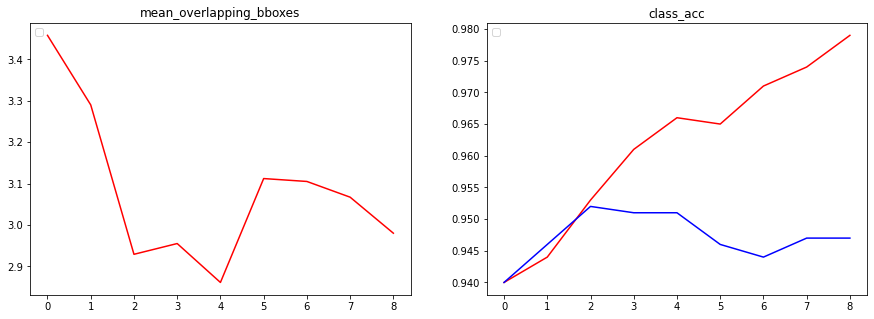

No handles with labels found to put in legend.
No handles with labels found to put in legend.


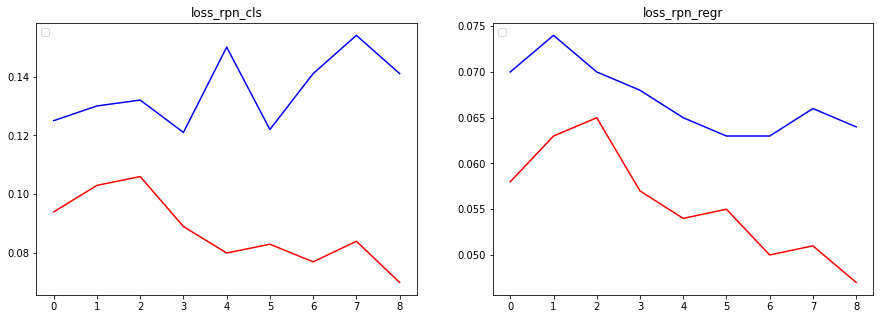

No handles with labels found to put in legend.
No handles with labels found to put in legend.


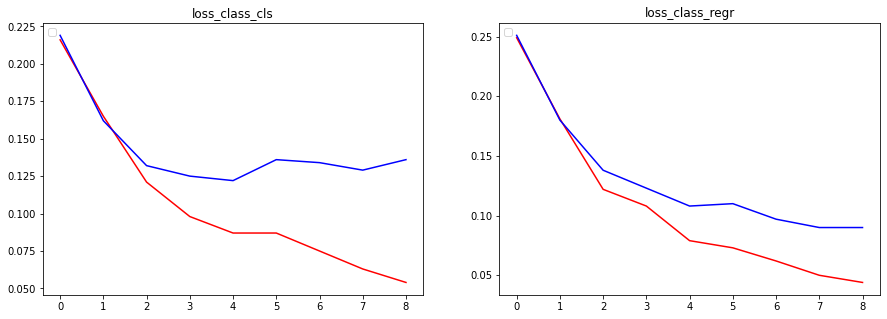

No handles with labels found to put in legend.


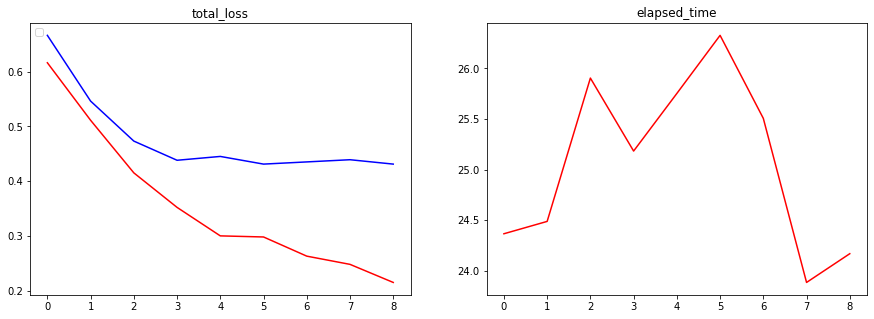

In [ ]:
# Load the records
record_df = pd.read_csv(C.record_path)
r_rpn = pd.read_csv(os.path.join(base_path, 'rpn/history_config_1.csv'))

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.legend(loc="upper left")
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r', record_df['val_class_acc'], 'b')
plt.legend(loc="upper left")
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r', record_df['val_loss_rpn_cls'], 'b')
plt.legend(loc="upper left")
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r', record_df['val_loss_rpn_regr'], 'b')
plt.legend(loc="upper left")
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r', record_df['val_loss_class_cls'], 'b')
plt.legend(loc="upper left")
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r', record_df['val_loss_class_regr'], 'b')
plt.legend(loc="upper left")
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r', record_df['val_curr_loss'], 'b')
plt.legend(loc="upper left")
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

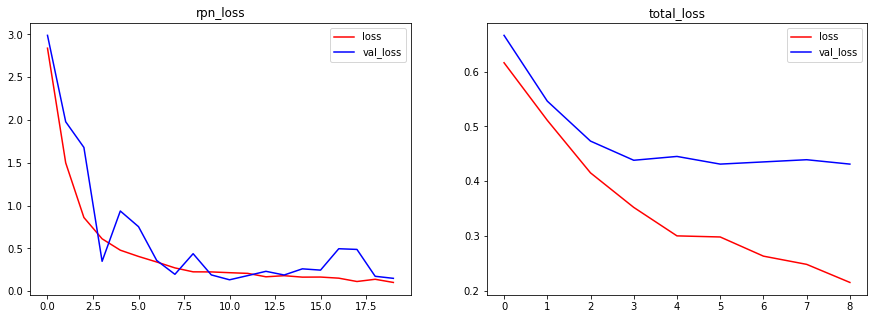

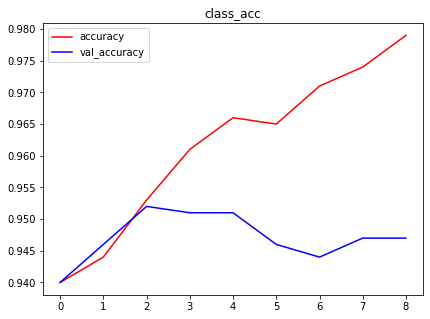

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
line1, = plt.plot(np.arange(0, len(r_rpn)), r_rpn['loss'], 'r')
line2, = plt.plot(np.arange(0, len(r_rpn)), r_rpn['val_loss'], 'b')
plt.legend(handles=[line1, line2],labels=['loss','val_loss'])
plt.title('rpn_loss')
plt.subplot(1,2,2)
line1, = plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
line2, = plt.plot(np.arange(0, r_epochs), record_df['val_curr_loss'], 'b')
plt.legend(handles=[line1, line2],labels=['loss','val_loss'])
plt.title('total_loss')

plt.show()


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
line1, = plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
line2, = plt.plot(np.arange(0, r_epochs), record_df['val_class_acc'], 'b')
plt.legend(handles=[line1, line2],labels=['accuracy','val_accuracy'])
plt.title('class_acc')

plt.show()

In [ ]:
# Load model path
C.model_path = os.path.join(base_path, 'default_config/best.VGG.adam.1e-5.EMTD.hdf5')
print("Model loaded")

Model loaded


In [ ]:
num_features = 512

if K.common.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
	input_shape_features = (num_features, None, None)
else:
	input_shape_img = (None, None, 3)
	input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn_base(img_input)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn(shared_layers, num_anchors)

classifier = classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier = Model([feature_map_input, roi_input], classifier)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='adam', loss='mse')
model_classifier.compile(optimizer='adam', loss='mse')

all_imgs = []

classes = {}

visualise = True

num_rois = C.num_rois


Loading weights from /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/models/default_config/best.VGG.adam.1e-5.EMTD.hdf5



In [ ]:
all_imgs = []
classes = {}

st = time.time()
all_imgs, _, _ = get_data(test_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

test_imgs = [s for s in all_imgs if (s['imageset'] == 'test' or s['imageset'] == 'trainval')]
print("test imgs: ", len(test_imgs))


Parsing annotation files
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/104.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/105.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/106.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/147.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/148.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/73.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/75.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/76.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/93.jpg
/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/109.jpg
/content/drive/My D

0/142
DEBUGGING 232 img_name: 104.jpg
img 0: 104.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/104.jpg

Elapsed time = 7.3281471729278564
pred_bboxs:  [{'x1': 642, 'x2': 655, 'y1': 419, 'y2': 432, 'class': 'traffic_sign', 'prob': 0.9947019}, {'x1': 642, 'x2': 655, 'y1': 406, 'y2': 419, 'class': 'traffic_sign', 'prob': 0.99073213}, {'x1': 668, 'x2': 681, 'y1': 393, 'y2': 406, 'class': 'traffic_sign', 'prob': 0.9760499}, {'x1': 642, 'x2': 668, 'y1': 406, 'y2': 432, 'class': 'traffic_sign', 'prob': 0.97250384}, {'x1': 642, 'x2': 668, 'y1': 406, 'y2': 419, 'class': 'traffic_sign', 'prob': 0.96686}, {'x1': 655, 'x2': 668, 'y1': 393, 'y2': 406, 'class': 'traffic_sign', 'prob': 0.9644446}, {'x1': 642, 'x2': 668, 'y1': 393, 'y2': 419, 'class': 'traffic_sign', 'prob': 0.9631225}, {'x1': 616, 'x2': 629, 'y1': 524, 'y2': 537, 'class': 'traffic_sign', 'prob': 0.9544839}, {'x1': 655, 'x2': 668, 'y1': 419, 'y2': 432, 'class': 'traffic

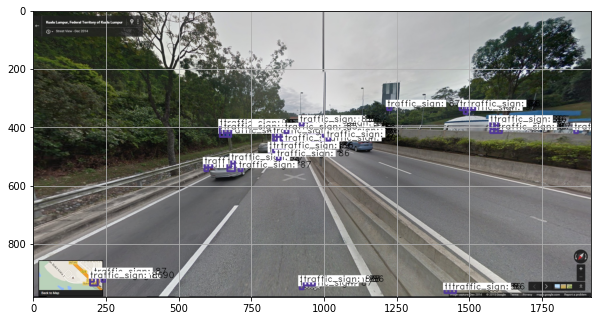

gt boxes: [{'class': 'traffic_sign', 'x1': 660, 'x2': 677, 'y1': 409, 'y2': 433, 'bbox_matched': False}]
traffic_sign AP: 0.010416666666666666
mAP = 0.010416666666666666
1/142
DEBUGGING 232 img_name: 105.jpg
img 1: 105.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/105.jpg
Elapsed time = 2.999171733856201
pred_bboxs:  [{'x1': 275, 'x2': 288, 'y1': 419, 'y2': 432, 'class': 'traffic_sign', 'prob': 0.97972345}, {'x1': 275, 'x2': 314, 'y1': 393, 'y2': 432, 'class': 'traffic_sign', 'prob': 0.9778311}, {'x1': 262, 'x2': 301, 'y1': 393, 'y2': 432, 'class': 'traffic_sign', 'prob': 0.9772423}, {'x1': 275, 'x2': 301, 'y1': 393, 'y2': 419, 'class': 'traffic_sign', 'prob': 0.9770686}, {'x1': 275, 'x2': 314, 'y1': 406, 'y2': 445, 'class': 'traffic_sign', 'prob': 0.9715415}, {'x1': 275, 'x2': 314, 'y1': 380, 'y2': 419, 'class': 'traffic_sign', 'prob': 0.96869177}, {'x1': 851, 'x2': 865, 'y1': 445, 'y2': 458, 'class': 'traffic_sign', 'p

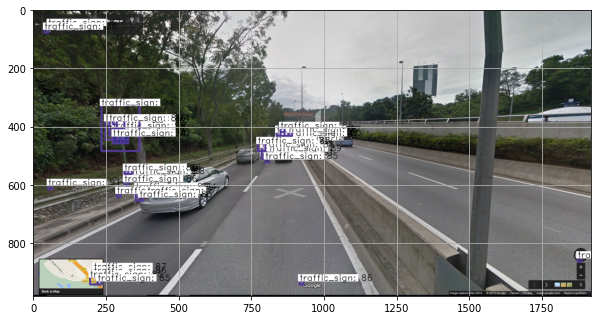

gt boxes: [{'class': 'traffic_sign', 'x1': 272, 'x2': 327, 'y1': 392, 'y2': 456, 'bbox_matched': False}]
traffic_sign AP: 0.012738853503184714
mAP = 0.012738853503184714
2/142
DEBUGGING 232 img_name: 106.jpg
img 2: 106.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/106.jpg
Elapsed time = 6.073046922683716
pred_bboxs:  [{'x1': 690, 'x2': 703, 'y1': 338, 'y2': 351, 'class': 'traffic_sign', 'prob': 0.9898385}, {'x1': 729, 'x2': 742, 'y1': 455, 'y2': 468, 'class': 'traffic_sign', 'prob': 0.989684}, {'x1': 716, 'x2': 729, 'y1': 442, 'y2': 455, 'class': 'traffic_sign', 'prob': 0.98730195}, {'x1': 690, 'x2': 703, 'y1': 325, 'y2': 338, 'class': 'traffic_sign', 'prob': 0.98676425}, {'x1': 742, 'x2': 755, 'y1': 455, 'y2': 468, 'class': 'traffic_sign', 'prob': 0.9860962}, {'x1': 690, 'x2': 703, 'y1': 312, 'y2': 325, 'class': 'traffic_sign', 'prob': 0.9833587}, {'x1': 716, 'x2': 729, 'y1': 455, 'y2': 468, 'class': 'traffic_sign', 'pr

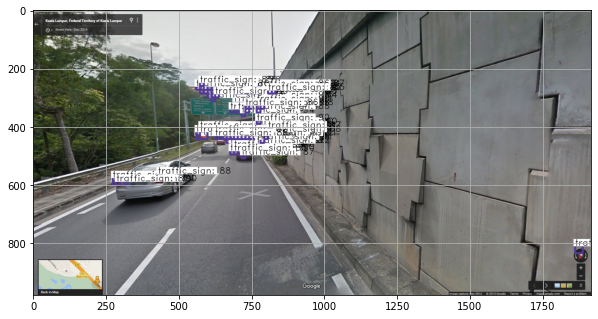

gt boxes: [{'class': 'traffic_sign', 'x1': 787, 'x2': 799, 'y1': 411, 'y2': 427, 'bbox_matched': False}]
traffic_sign AP: 0.010380622837370242
mAP = 0.010380622837370242
3/142
DEBUGGING 232 img_name: 147.jpg
img 3: 147.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/147.jpg
Elapsed time = 4.664796352386475
pred_bboxs:  [{'x1': 1190, 'x2': 1203, 'y1': 549, 'y2': 562, 'class': 'traffic_sign', 'prob': 0.96235776}, {'x1': 1190, 'x2': 1203, 'y1': 562, 'y2': 575, 'class': 'traffic_sign', 'prob': 0.95304275}, {'x1': 1203, 'x2': 1216, 'y1': 536, 'y2': 549, 'class': 'traffic_sign', 'prob': 0.952824}, {'x1': 78, 'x2': 91, 'y1': 889, 'y2': 915, 'class': 'traffic_sign', 'prob': 0.9424556}, {'x1': 1517, 'x2': 1530, 'y1': 523, 'y2': 536, 'class': 'traffic_sign', 'prob': 0.9382414}, {'x1': 1438, 'x2': 1451, 'y1': 562, 'y2': 575, 'class': 'traffic_sign', 'prob': 0.9370645}, {'x1': 1530, 'x2': 1543, 'y1': 523, 'y2': 536, 'class': 'traffic_

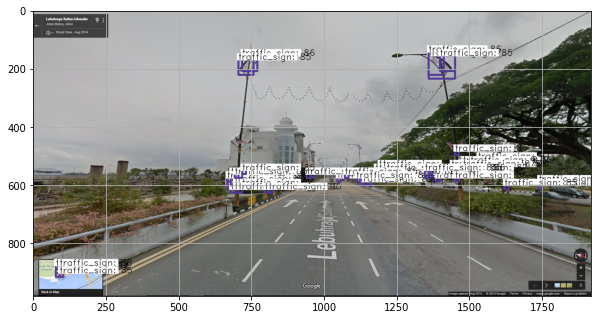

gt boxes: [{'class': 'traffic_sign', 'x1': 1210, 'x2': 1225, 'y1': 551, 'y2': 574, 'bbox_matched': False}]
traffic_sign AP: 0.010582010582010581
mAP = 0.010582010582010581
4/142
DEBUGGING 232 img_name: 148.jpg
img 4: 148.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/148.jpg
Elapsed time = 4.218451023101807
pred_bboxs:  [{'x1': 1344, 'x2': 1357, 'y1': 548, 'y2': 561, 'class': 'traffic_sign', 'prob': 0.9820551}, {'x1': 1357, 'x2': 1370, 'y1': 548, 'y2': 561, 'class': 'traffic_sign', 'prob': 0.97784823}, {'x1': 1344, 'x2': 1357, 'y1': 535, 'y2': 548, 'class': 'traffic_sign', 'prob': 0.97577775}, {'x1': 1696, 'x2': 1709, 'y1': 535, 'y2': 548, 'class': 'traffic_sign', 'prob': 0.9680569}, {'x1': 1357, 'x2': 1370, 'y1': 535, 'y2': 561, 'class': 'traffic_sign', 'prob': 0.96668166}, {'x1': 1344, 'x2': 1370, 'y1': 535, 'y2': 561, 'class': 'traffic_sign', 'prob': 0.96585643}, {'x1': 1696, 'x2': 1709, 'y1': 522, 'y2': 548, 'class': 

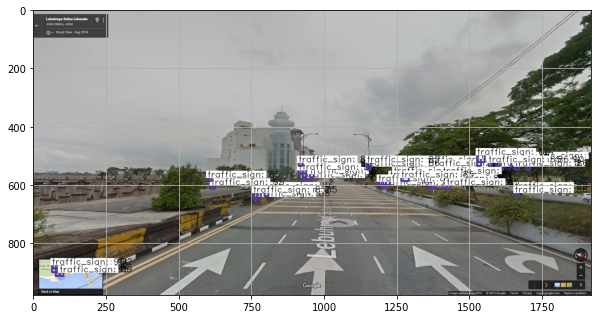

gt boxes: [{'class': 'traffic_sign', 'x1': 1358, 'x2': 1384, 'y1': 537, 'y2': 576, 'bbox_matched': False}]
traffic_sign AP: 0.010570824524312896
mAP = 0.010570824524312896
5/142
DEBUGGING 232 img_name: 73.jpg
img 5: 73.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/73.jpg
Elapsed time = 4.715085983276367
pred_bboxs:  [{'x1': 732, 'x2': 745, 'y1': 431, 'y2': 444, 'class': 'traffic_sign', 'prob': 0.98114544}, {'x1': 732, 'x2': 745, 'y1': 444, 'y2': 457, 'class': 'traffic_sign', 'prob': 0.9790652}, {'x1': 758, 'x2': 771, 'y1': 431, 'y2': 444, 'class': 'traffic_sign', 'prob': 0.9729633}, {'x1': 706, 'x2': 719, 'y1': 510, 'y2': 523, 'class': 'traffic_sign', 'prob': 0.97231704}, {'x1': 902, 'x2': 915, 'y1': 457, 'y2': 470, 'class': 'traffic_sign', 'prob': 0.9665873}, {'x1': 719, 'x2': 732, 'y1': 444, 'y2': 457, 'class': 'traffic_sign', 'prob': 0.96639574}, {'x1': 680, 'x2': 693, 'y1': 510, 'y2': 523, 'class': 'traffic_sign', 'p

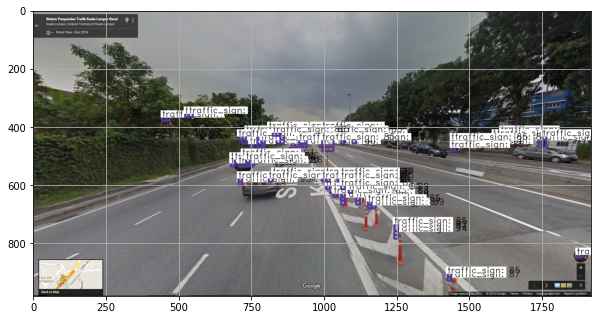

gt boxes: [{'class': 'traffic_sign', 'x1': 748, 'x2': 759, 'y1': 442, 'y2': 457, 'bbox_matched': False}, {'class': 'traffic_sign', 'x1': 819, 'x2': 828, 'y1': 436, 'y2': 444, 'bbox_matched': False}, {'class': 'traffic_sign', 'x1': 999, 'x2': 1031, 'y1': 412, 'y2': 446, 'bbox_matched': False}]
traffic_sign AP: 0.012861736334405145
mAP = 0.012861736334405145
6/142
DEBUGGING 232 img_name: 75.jpg
img 6: 75.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/75.jpg
Elapsed time = 5.419605493545532
pred_bboxs:  [{'x1': 996, 'x2': 1009, 'y1': 471, 'y2': 484, 'class': 'traffic_sign', 'prob': 0.9937337}, {'x1': 996, 'x2': 1009, 'y1': 458, 'y2': 484, 'class': 'traffic_sign', 'prob': 0.99239963}, {'x1': 982, 'x2': 996, 'y1': 458, 'y2': 471, 'class': 'traffic_sign', 'prob': 0.9874356}, {'x1': 996, 'x2': 1022, 'y1': 458, 'y2': 484, 'class': 'traffic_sign', 'prob': 0.9862316}, {'x1': 930, 'x2': 943, 'y1': 498, 'y2': 511, 'class': 'traffic_s

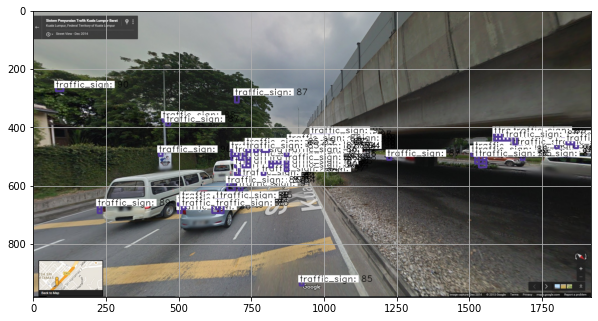

gt boxes: [{'class': 'traffic_sign', 'x1': 1000, 'x2': 1027, 'y1': 453, 'y2': 494, 'bbox_matched': False}, {'class': 'traffic_sign', 'x1': 945, 'x2': 962, 'y1': 481, 'y2': 498, 'bbox_matched': False}]
traffic_sign AP: 0.012254901960784314
mAP = 0.012254901960784314
7/142
DEBUGGING 232 img_name: 76.jpg
img 7: 76.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/76.jpg
Elapsed time = 4.8974878787994385
pred_bboxs:  [{'x1': 1517, 'x2': 1530, 'y1': 418, 'y2': 431, 'class': 'traffic_sign', 'prob': 0.9716204}, {'x1': 1072, 'x2': 1085, 'y1': 392, 'y2': 405, 'class': 'traffic_sign', 'prob': 0.9653328}, {'x1': 1059, 'x2': 1072, 'y1': 405, 'y2': 418, 'class': 'traffic_sign', 'prob': 0.9616941}, {'x1': 1059, 'x2': 1072, 'y1': 418, 'y2': 431, 'class': 'traffic_sign', 'prob': 0.9614524}, {'x1': 1412, 'x2': 1464, 'y1': 379, 'y2': 444, 'class': 'traffic_sign', 'prob': 0.96124136}, {'x1': 1504, 'x2': 1517, 'y1': 405, 'y2': 418, 'class': 'tr

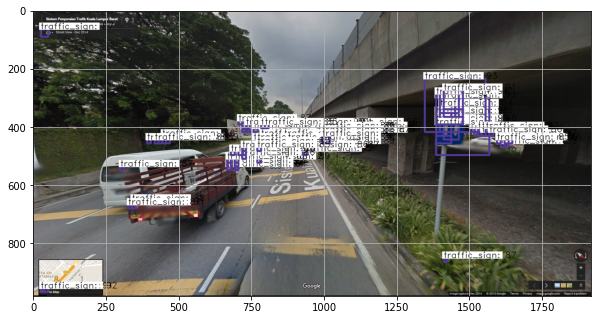

gt boxes: [{'class': 'traffic_sign', 'x1': 1387, 'x2': 1497, 'y1': 280, 'y2': 464, 'bbox_matched': False}, {'class': 'traffic_sign', 'x1': 995, 'x2': 1026, 'y1': 415, 'y2': 445, 'bbox_matched': False}]
traffic_sign AP: 0.012396694214876033
mAP = 0.012396694214876033
8/142
DEBUGGING 232 img_name: 93.jpg
img 8: 93.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/93.jpg
Elapsed time = 4.589273691177368
pred_bboxs:  [{'x1': 744, 'x2': 757, 'y1': 430, 'y2': 443, 'class': 'traffic_sign', 'prob': 0.99064624}, {'x1': 744, 'x2': 757, 'y1': 417, 'y2': 430, 'class': 'traffic_sign', 'prob': 0.9852342}, {'x1': 744, 'x2': 770, 'y1': 417, 'y2': 443, 'class': 'traffic_sign', 'prob': 0.9545313}, {'x1': 744, 'x2': 770, 'y1': 417, 'y2': 430, 'class': 'traffic_sign', 'prob': 0.94542}, {'x1': 757, 'x2': 783, 'y1': 404, 'y2': 430, 'class': 'traffic_sign', 'prob': 0.9394973}, {'x1': 26, 'x2': 39, 'y1': 52, 'y2': 65, 'class': 'traffic_sign', 'prob

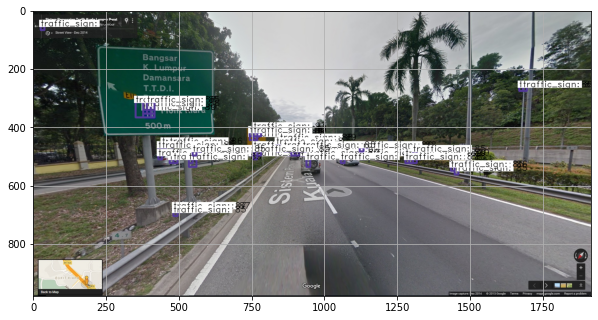

gt boxes: [{'class': 'traffic_sign', 'x1': 380, 'x2': 421, 'y1': 316, 'y2': 371, 'bbox_matched': False}, {'class': 'traffic_sign', 'x1': 757, 'x2': 780, 'y1': 422, 'y2': 443, 'bbox_matched': False}]
traffic_sign AP: 0.01334604385128694
mAP = 0.01334604385128694
9/142
DEBUGGING 232 img_name: 109.jpg
img 9: 109.jpg
DEBUGGING filepath: /content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/data/Detection/109.jpg


In [ ]:
T = {}
P = {}
mAPs = []
counter = 0

pred_df = pd.DataFrame(
        columns=['file_path', 'xmin_pred', 'ymin_pred', 'xmax_pred', 'ymax_pred', 'class_pred'])

for idx, img_data in enumerate(test_imgs):
	print('{}/{}'.format(idx, len(test_imgs)))
	img_name = img_data['filepath'].split('/')[-1]
	print("DEBUGGING 232 img_name:", img_name)
	print("img {}: {}".format(str(counter), img_name))
	st = time.time()
	img_path = img_data['filepath']
	filepath = img_path
	print("DEBUGGING filepath:", filepath)
	img = cv2.imread(filepath)
	counter += 1

  # preprocess image
	X, ratio, fx, fy = format_img(img, C)
 
	if K.common.image_dim_ordering() == 'tf':
		X = np.transpose(X, (0, 2, 3, 1))
	# get the feature maps and output from the RPN
	[Y1, Y2, F] = model_rpn.predict(X)
	
	R = rpn_to_roi(Y1, Y2, C, K.common.image_dim_ordering(), overlap_thresh=0.7)
	# print(R.shape)
	X2, Y1, Y2, IouS = calc_iou(R, img_data, C, C.class_mapping)
    
	# convert from (x1,y1,x2,y2) to (x,y,w,h)
	R[:, 2] -= R[:, 0]
	R[:, 3] -= R[:, 1]

	# apply the spatial pyramid pooling to the proposed regions
	bboxes = {}
	probs = {}
	for jk in range(R.shape[0]//num_rois + 1):
		ROIs = np.expand_dims(R[num_rois*jk:num_rois*(jk+1),:],axis=0)
		if ROIs.shape[1] == 0:
			break

		if jk == R.shape[0]//num_rois:
			#pad R
			curr_shape = ROIs.shape
			target_shape = (curr_shape[0],num_rois,curr_shape[2])
			ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
			ROIs_padded[:,:curr_shape[1],:] = ROIs
			ROIs_padded[0,curr_shape[1]:,:] = ROIs[0,0,:]
			ROIs = ROIs_padded

		[P_cls,P_regr] = model_classifier.predict([F, ROIs])

		for ii in range(P_cls.shape[1]):

			if np.max(P_cls[0, ii, :]) < 0.85 or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
				continue
			
			cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

			if cls_name not in bboxes:
					bboxes[cls_name] = []
					probs[cls_name] = []

			(x, y, w, h) = ROIs[0, ii, :]

			cls_num = np.argmax(P_cls[0, ii, :])
			try:
					(tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
					tx /= C.classifier_regr_std[0]
					ty /= C.classifier_regr_std[1]
					tw /= C.classifier_regr_std[2]
					th /= C.classifier_regr_std[3]
					x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
			except:
					pass
			bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
			probs[cls_name].append(np.max(P_cls[0, ii, :]))

	# bboxes.pop('bg')    # added to avoid plotting background bbox
	# probs.pop('bg')     # added to avoid plotting background bbox

	all_dets = []

	for key in bboxes:
		
		bbox = np.array(bboxes[key])

		new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh = 0.5)
		for jk in range(new_boxes.shape[0]):
			(x1, y1, x2, y2) = new_boxes[jk,:]
			(real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

			cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),5)

			textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
			det = {'x1': real_x1, 'x2': real_x2, 'y1': real_y1, 'y2': real_y2, 'class': key, 'prob': new_probs[jk]}
			if len(det) != 0:
				new_row = {'file_path': filepath,
                           'xmin_pred': det['x1'],
                           'ymin_pred': det['y1'],
                           'xmax_pred': det['x2'],
                           'ymax_pred': det['y2'],
                           'class_pred': det['class']}
				pred_df = pred_df.append(new_row, ignore_index=True)
				pred_df.to_csv(record_path, index=0)
			all_dets.append(det)
	 
			(retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,0.75,1)
			textOrg = (real_x1, real_y1-0)
	 	
			cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
			cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

	print('Elapsed time = {}'.format(time.time() - st))
	print("pred_bboxs: ", all_dets)
	plt.figure(figsize=(10,10))
	plt.grid()
	plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
	plt.show()
  # enable if you want to show pics
	if len(all_dets) != 0:
		cv2.imwrite("/content/drive/My Drive/Colab Notebooks/TA/frcnn-from-scratch-with-keras/images/Model_Config1/{}".format(img_name), img)
	t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
	print("gt boxes:", img_data['bboxes'])
	for key in t.keys():
		if key not in T:
			T[key] = []
			P[key] = []
		T[key].extend(t[key])
		P[key].extend(p[key])
	all_aps = []
	for key in T.keys():
		ap = average_precision_score(T[key], P[key])
		print('{} AP: {}'.format(key, ap))
		all_aps.append(ap)
	print('mAP = {}'.format(np.mean(np.array(all_aps))))
	mAPs.append(np.mean(np.array(all_aps)))
print()
print('mean average precision:', np.mean(np.array(mAPs)))

In [ ]:
print()
print('mean average precision:', np.mean(np.array(mAPs)))

# EVAL

In [ ]:
preds = pd.read_csv(os.path.join(base_path, 'default_config/r_pred.0.534.csv'))
gt = pd.read_csv(test_path, header=None)

In [ ]:
preds.head()

,file_path,xmin_pred,ymin_pred,xmax_pred,ymax_pred,class_pred
0,/content/drive/My Drive/Colab Notebooks/TA/frc...,655,406,681,432,traffic_sign
1,/content/drive/My Drive/Colab Notebooks/TA/frc...,275,380,327,458,traffic_sign
2,/content/drive/My Drive/Colab Notebooks/TA/frc...,1357,535,1383,574,traffic_sign
3,/content/drive/My Drive/Colab Notebooks/TA/frc...,996,445,1035,498,traffic_sign
4,/content/drive/My Drive/Colab Notebooks/TA/frc...,378,313,417,365,traffic_sign


In [ ]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   193 non-null    object
 1   xmin_pred   193 non-null    int64 
 2   ymin_pred   193 non-null    int64 
 3   xmax_pred   193 non-null    int64 
 4   ymax_pred   193 non-null    int64 
 5   class_pred  193 non-null    object
dtypes: int64(4), object(2)
memory usage: 9.2+ KB


In [ ]:
gt.columns = ['file_path', 'xmin', 'ymin', 'xmax', 'ymax', 'class']
gt.head()

,file_path,xmin,ymin,xmax,ymax,class
0,/content/drive/My Drive/Colab Notebooks/TA/frc...,660,409,677,433,traffic_sign
1,/content/drive/My Drive/Colab Notebooks/TA/frc...,272,392,327,456,traffic_sign
2,/content/drive/My Drive/Colab Notebooks/TA/frc...,787,411,799,427,traffic_sign
3,/content/drive/My Drive/Colab Notebooks/TA/frc...,1210,551,1225,574,traffic_sign
4,/content/drive/My Drive/Colab Notebooks/TA/frc...,1358,537,1384,576,traffic_sign


In [ ]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  197 non-null    object
 1   xmin       197 non-null    int64 
 2   ymin       197 non-null    int64 
 3   xmax       197 non-null    int64 
 4   ymax       197 non-null    int64 
 5   class      197 non-null    object
dtypes: int64(4), object(2)
memory usage: 9.4+ KB


In [ ]:
join = pd.merge(gt, preds, how='left', on=['file_path'])
join.head()

,file_path,xmin,ymin,xmax,ymax,class,xmin_pred,ymin_pred,xmax_pred,ymax_pred,class_pred
0,/content/drive/My Drive/Colab Notebooks/TA/frc...,660,409,677,433,traffic_sign,655.0,406.0,681.0,432.0,traffic_sign
1,/content/drive/My Drive/Colab Notebooks/TA/frc...,272,392,327,456,traffic_sign,275.0,380.0,327.0,458.0,traffic_sign
2,/content/drive/My Drive/Colab Notebooks/TA/frc...,787,411,799,427,traffic_sign,NaN,NaN,NaN,NaN,NaN
3,/content/drive/My Drive/Colab Notebooks/TA/frc...,1210,551,1225,574,traffic_sign,NaN,NaN,NaN,NaN,NaN
4,/content/drive/My Drive/Colab Notebooks/TA/frc...,1358,537,1384,576,traffic_sign,1357.0,535.0,1383.0,574.0,traffic_sign


In [ ]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 333
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   334 non-null    object 
 1   xmin        334 non-null    int64  
 2   ymin        334 non-null    int64  
 3   xmax        334 non-null    int64  
 4   ymax        334 non-null    int64  
 5   class       334 non-null    object 
 6   xmin_pred   287 non-null    float64
 7   ymin_pred   287 non-null    float64
 8   xmax_pred   287 non-null    float64
 9   ymax_pred   287 non-null    float64
 10  class_pred  287 non-null    object 
dtypes: float64(4), int64(4), object(3)
memory usage: 31.3+ KB


In [ ]:
join['class_pred'] = join['class_pred'].fillna('bg')
join

,file_path,xmin,ymin,xmax,ymax,class,xmin_pred,ymin_pred,xmax_pred,ymax_pred,class_pred
0,/content/drive/My Drive/Colab Notebooks/TA/frc...,660,409,677,433,traffic_sign,655.0,406.0,681.0,432.0,traffic_sign
1,/content/drive/My Drive/Colab Notebooks/TA/frc...,272,392,327,456,traffic_sign,275.0,380.0,327.0,458.0,traffic_sign
2,/content/drive/My Drive/Colab Notebooks/TA/frc...,787,411,799,427,traffic_sign,NaN,NaN,NaN,NaN,bg
3,/content/drive/My Drive/Colab Notebooks/TA/frc...,1210,551,1225,574,traffic_sign,NaN,NaN,NaN,NaN,bg
4,/content/drive/My Drive/Colab Notebooks/TA/frc...,1358,537,1384,576,traffic_sign,1357.0,535.0,1383.0,574.0,traffic_sign
...,...,...,...,...,...,...,...,...,...,...,...
329,/content/drive/My Drive/Colab Notebooks/TA/frc...,515,493,557,541,traffic_sign,1281.0,497.0,1347.0,575.0,traffic_sign
330,/content/drive/My Drive/Colab Notebooks/TA/frc...,515,493,557,541,traffic_sign,1870.0,824.0,1896.0,850.0,traffic_sign
331,/content/drive/My Drive/Colab Notebooks/TA/frc...,1291,503,1352,569,traffic_sign,510.0,483.0,562.0,536.0,traffic_sign
332,/content/drive/My Drive/Colab Notebooks/TA/frc...,1291,503,1352,569,traffic_sign,1281.0,497.0,1347.0,575.0,traffic_sign
